In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install torchviz


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=da8bf56395a2ff5673b6063c7ea2f3466f3f5468861e3685af60f1b910bf2485
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


Import Some **Necessary Libraries**. Here, The **cudnn.benchmark = True** line enables the CuDNN benchmarking, which can improve the performance of **convolutional neural networks** on GPU. The **plt.ion()** line enables interactive plotting mode in **matplotlib.**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torchsummary import summary
from torchviz import make_dot

cudnn.benchmark = True
plt.ion()

Two sets of transformations are defined for training and testing data.
**Training set:** random resized crop, random horizontal flip, tensor conversion, and normalization.
**Test set:** resize, center crop, tensor conversion, and normalization (with same parameters as training).
**ImageFolder datasets** are created for train and test sets from the specified directory.
**DataLoader instance**s are created for both sets with a batch size of 4, shuffling for train set, and 4 workers for loading data.
**dataset_sizes** stores the number of images in each set, and class_names stores the class names from the train set.
The device variable is set to use **CUDA GPU** if available, otherwise CPU.

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Animal Dataset'
transforms = data_transforms.keys()

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x, x),
                                          data_transforms[x])
                  for x in transforms}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in transforms}
dataset_sizes = {x: len(image_datasets[x]) for x in transforms}
class_names = image_datasets['train'].classes

print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['Nilgai', 'cow', 'horse', 'water buffelo']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


- The **`imshow`** function displays images from a PyTorch tensor.
- It converts the tensor to a **NumPy array and reshapes** it to (height, width, channels).
- **Denormalization** is applied by multiplying by the standard deviation and adding the mean.
- **`np.clip`** ensures pixel values are in the valid range of [0, 1].
- The function uses **`plt.imshow`** to display the image, with an optional title.
**- `torchvision.utils.make_grid(inputs)` **creates a grid of images from the batch.
- The** `imshow`** function displays the grid with class labels as titles.

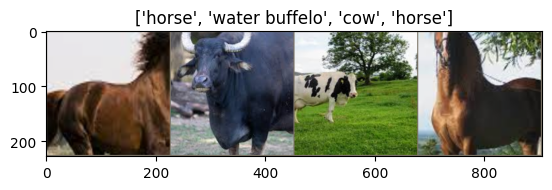

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

- The function **plots training and validation loss**, as well as training and validation accuracy, over epochs.
- **It takes four lists as arguments:** train_losses, val_losses, train_acc, and val_acc.
- **It creates a figure with two subplots**: one for loss and one for accuracy.
- The **left subplot **shows the **training and validation** losses over epochs.
- The **right subplot** shows the **training and validation** accuracies over epochs.
- It adds labels to the axes and a legend to differentiate between **training and validation data.**
- The plots help **visualize** the training progress and identify potential issues like overfitting or underfitting.

In [5]:
def plot_training_results(train_losses, val_losses, train_acc, val_acc):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

- The **function trains** a PyTorch model for a specified number of epochs.
- It **iterates** over epochs, setting the model to **training or evaluation mode.**
- For each phase **(train or test)**, it iterates over batches, computes loss and accuracy, and updates the model's weights if in training mode.
- It saves the **best model parameters** based on validation accuracy.
- **After training,** it loads the best model parameters, prints the best test accuracy, and plots training results.

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in transforms:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Save losses and accuracies for later plotting
                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_acc.append(epoch_acc.cpu().numpy())  # Convert to numpy array on CPU
                else:
                    val_losses.append(epoch_loss)
                    val_acc.append(epoch_acc.cpu().numpy())  # Convert to numpy array on CPU

                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best test Acc: {best_acc:.4f}')

        # Load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    # Plot the training results
    plot_training_results(train_losses, val_losses, train_acc, val_acc)

    return model

- The **`visualize_model`** function visualizes the predictions of a trained **PyTorch model** on a small number of images from the test set.
- It temporarily sets the model to **evaluation mode** to disable dropout and batch normalization layers.
- It **iterates** over batches of images from the **test dataloader** and passes them through the model to obtain predictions.
- For each image in the batch, it displays the image along with the predicted class label as the title, using the **`imshow`** function.
- The function stops after visualizing **`num_images`** or all images in the test set, whichever comes first.
- It then restores the **model's training mode** to its original state

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

- Here fine-tunes a **ResNet-18** model pretrained on ImageNet for a new **classification** task.
- It **replaces** the fully connected layer of the **pretrained model** with a new **linear layer** for the custom number of classes.
- The model is moved to the **GPU** if available, otherwise to the **CPU**.
**- Cross-entropy loss** is used as the loss function for classification.
- **Stochastic gradient descent (SGD)** is chosen as the optimizer with a learning rate of 0.001 and momentum of **0.9.**
- A learning rate scheduler is implemented to decrease the learning rate by a factor of **0.1 every 7 epochs.**
- The setup prepares the **ResNet-18 model** for **fine-tuning** on the new **classification task** with the **specified parameters**.

In [8]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]


- The **ResNet-18 model** (model_ft) is trained for** 5 epochs.**
- **Cross-entropy los**s is used as the criterion for **training.**
- **Stochastic Gradient Descent (SGD)** optimizer is used with a learning rate of 0.001 and momentum of **0.9.**
- **Learning rate** is decreased by a factor of 0.1 every 7 epochs using a scheduler.
- The **train_model function** is called to train and validate the model.
- The **function returns** the trained model after completion.

Epoch 0/4
----------
train Loss: 1.2360 Acc: 0.4419
test Loss: 0.2191 Acc: 0.9688

Epoch 1/4
----------
train Loss: 1.0163 Acc: 0.6213
test Loss: 0.2078 Acc: 0.9375

Epoch 2/4
----------
train Loss: 0.7499 Acc: 0.7342
test Loss: 0.0470 Acc: 1.0000

Epoch 3/4
----------
train Loss: 0.7510 Acc: 0.7209
test Loss: 0.2137 Acc: 0.9062

Epoch 4/4
----------
train Loss: 0.7386 Acc: 0.7176
test Loss: 0.0613 Acc: 0.9688

Training complete in 0m 44s
Best test Acc: 1.0000


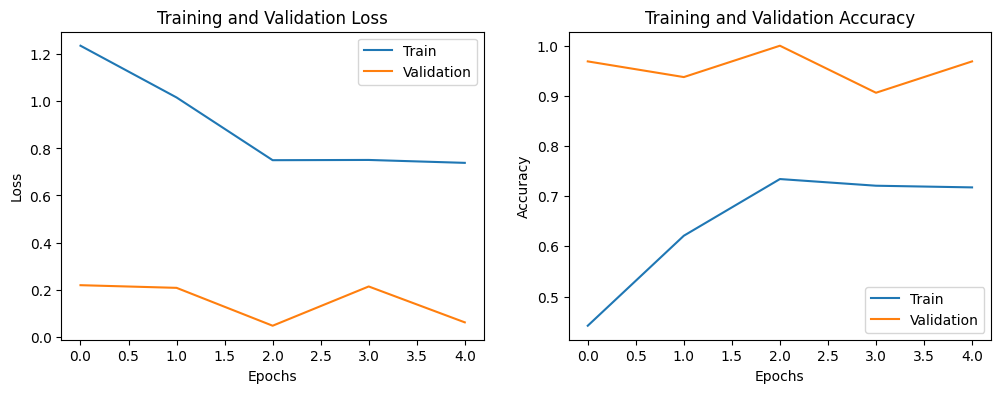

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

- The function sets the model to **evaluation mode** and iterates over a batch of images from the test dataset.
- For each image, it makes a **prediction using the model** and **displays the image** along with the predicted class label.
- It stops after **displaying** the specified number of images or when all images in the batch have been processed.
- Finally, it sets the model back to its **original training mode**.

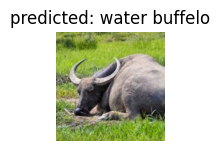

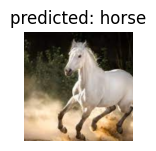

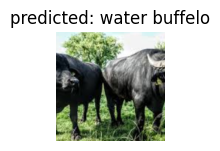

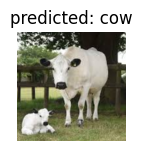

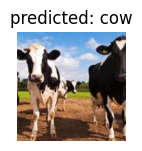

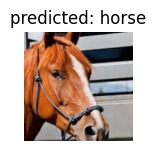

In [11]:
visualize_model(model_ft)

The code **freezes** the parameters of the **pretrained ResNet-18 model**
modifies the fully **connected layer (fc)** of the ResNet-18 model to have the same number of output features as the number of classes in the dataset.
It modified model to the **specified device (GPU or CPU).**
It sets up an optimizer **(optim.SGD)** to update only the parameters of the final layer (fc) during training, with a **learning rate of 0.001** and **momentum of 0.9.**
  It also decay the learning rate by a factor **of 0.1 every 7 epochs .**


In [12]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

- The **`train_model`** function is used to train the **`model_conv`** n**eural network.**
- It uses the specified **`criterion` (loss function)** to calculate the loss during training.
- The **`optimizer_conv`** optimizer is used to update the weights of the fully connected layers.
- The **`exp_lr_scheduler**` is a learning rate scheduler that adjusts the learning rate during training.
- The training is performed for **`num_epochs=5`** epochs, iterating over the training and validation datasets.
- The function updates the model's weights based on the loss and **adjusts the learning rate** according to the scheduler.
- After training, the function returns the trained **`model_conv`** neural network.

Epoch 0/4
----------
train Loss: 1.3223 Acc: 0.3887
test Loss: 0.4475 Acc: 0.8750

Epoch 1/4
----------
train Loss: 0.8224 Acc: 0.6744
test Loss: 0.1490 Acc: 0.9688

Epoch 2/4
----------
train Loss: 0.8385 Acc: 0.7076
test Loss: 0.1569 Acc: 1.0000

Epoch 3/4
----------
train Loss: 0.7707 Acc: 0.6977
test Loss: 0.1334 Acc: 0.9688

Epoch 4/4
----------
train Loss: 0.7696 Acc: 0.7110
test Loss: 0.1105 Acc: 0.9688

Training complete in 0m 12s
Best test Acc: 1.0000


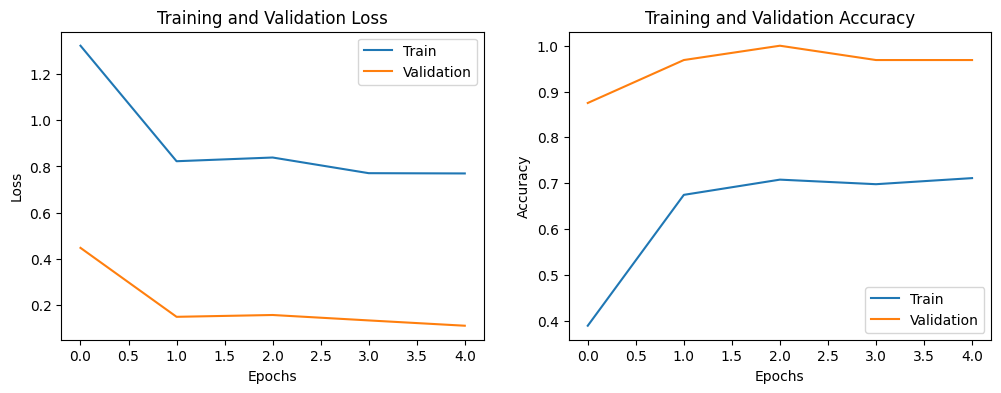

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

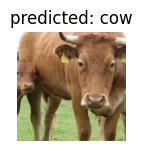

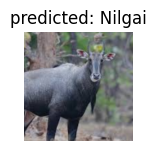

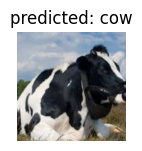

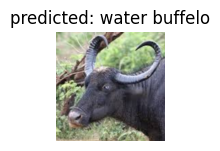

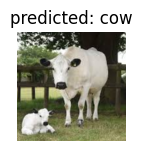

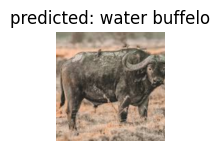

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()

**- `summary` function:** Provides a summary of `model_ft` architecture, including layers and parameters.
**- Input size:** Specifies model input size as (3, 224, 224) for RGB images of size 224x224 pixels.
**- `device` type:** Specifies the device type (`"cuda:0"` for GPU or `"cpu"` for CPU) for model execution.
**- `make_dot` function:** Generates a computation graph visualization for the model using dummy input.
**- Rendering:** Renders the computation graph as an image named "model_architecture.png".
**- Visualization:** Helps understand data flow and connections between layers, aiding in model debugging and optimization.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

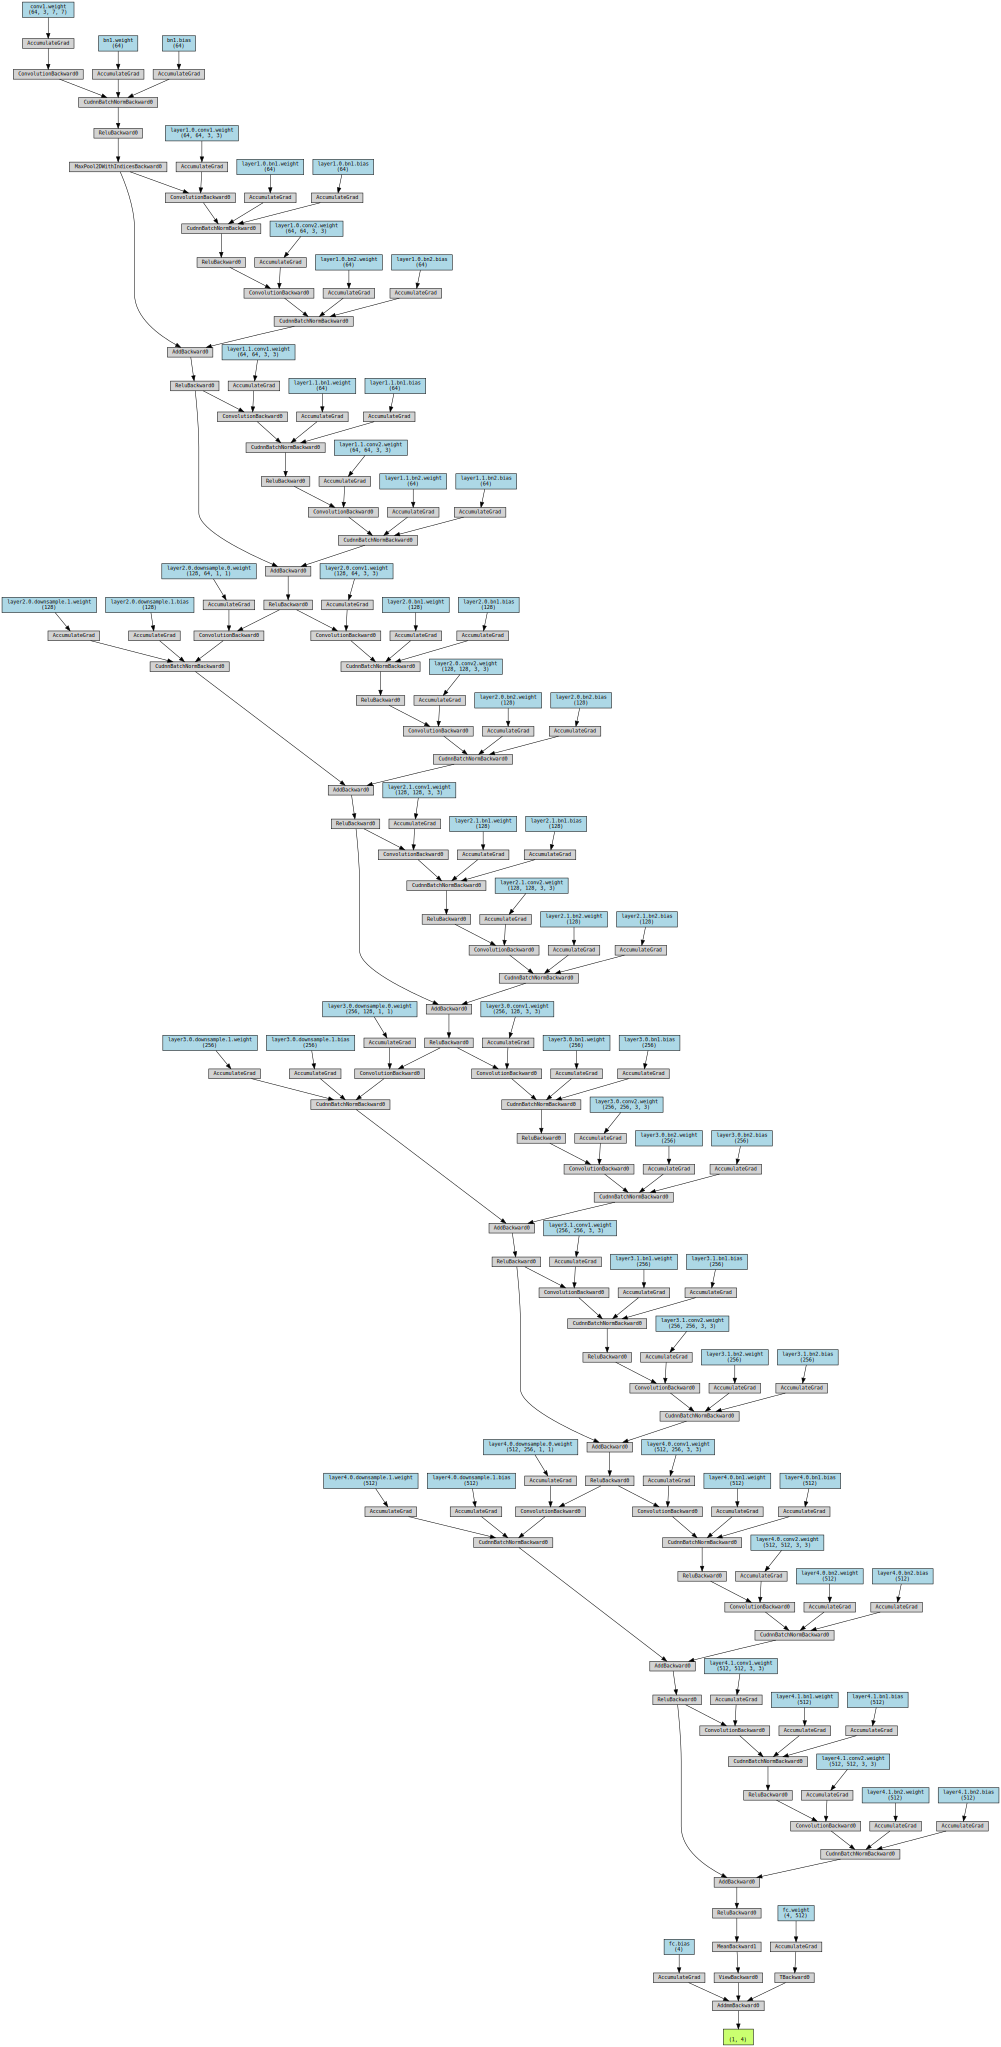

In [15]:
summary(model_ft, input_size=(3, 224, 224), device=device.type)

# Generate a visualization plot for the model
dummy_input = torch.randn(1, 3, 224, 224).to(device)
model_ft.to(device)
dot = make_dot(model_ft(dummy_input), params=dict(model_ft.named_parameters()))
dot.render("model_architecture", format="png", cleanup=True)

dot